In [1]:
import os, datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2023-09-10 18:03:52.088695: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data = pd.read_csv('../datasets/life_expectancy.csv')
data.sample(5)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
2693,Turkey,2003,Developing,71.6,135.0,35,1.42,459.111306,68.0,5844,...,69.0,5.34,68.0,0.1,4718.512910,668583.0,5.1,5.0,0.668,11.9
2364,Solomon Islands,2012,Developing,68.7,184.0,0,0.01,247.949228,99.0,0,...,99.0,5.48,99.0,0.1,1858.689868,551531.0,1.2,1.2,0.505,9.4
2419,South Sudan,2005,Developing,51.9,383.0,28,NaN,0.000000,NaN,0,...,NaN,NaN,NaN,3.9,NaN,818877.0,NaN,NaN,0.000,0.0
1613,Maldives,2004,Developing,73.4,16.0,0,1.60,611.909357,97.0,37,...,96.0,5.89,96.0,0.1,3853.333480,312.0,14.5,14.6,0.617,12.2
2682,Turkey,2014,Developing,75.5,17.0,16,1.45,181.908378,96.0,565,...,96.0,5.41,96.0,0.1,12127.225220,773628.0,4.9,4.7,0.759,14.5


In [3]:
data.isna().sum() #find columns with missing fields

Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
 BMI                                34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
 HIV/AIDS                            0
GDP                                448
Population                         652
 thinness  1-19 years               34
 thinness 5-9 years                 34
Income composition of resources    167
Schooling                          163
dtype: int64

In [4]:
countries = data['Country'].unique()
na_cols = ['Life expectancy ', 'Adult Mortality', 'Alcohol', 'Hepatitis B', ' BMI ', 'Polio',
           'Total expenditure', 'Diphtheria ', 'GDP', ' thinness  1-19 years', ' thinness 5-9 years',
           'Population', 'Income composition of resources']
for col in na_cols:
    for country in countries:
        data.loc[data['Country']== country, col] = data.loc[data['Country']== country, col]\
                                                        .fillna(data[data['Country'] == country][col].mean())
        

In [5]:
data.isna().sum() # still missing data
data = data.dropna()

In [6]:
data['Status'].value_counts()

Status
Developing    1824
Developed      304
Name: count, dtype: int64

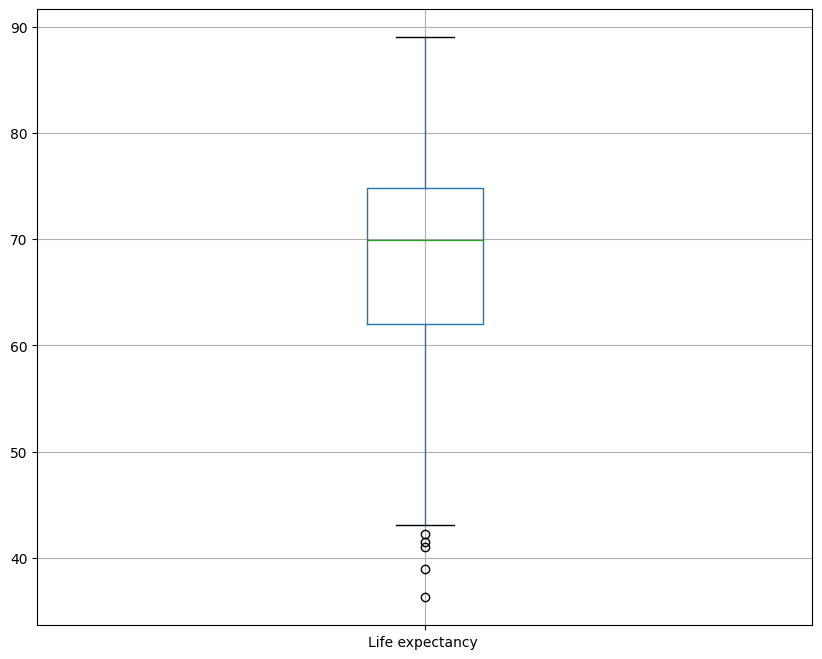

In [10]:
plt.figure(figsize=(10, 8))
data.boxplot('Life expectancy ') # box plot of life expectancy across countries
plt.show()

In [7]:
# compare between deveeloped and developing
plt.figure(figsize=(8, 6))
sns.boxplot('Status', 'Life expectancy ', data=data)
plt.xlabel('Status', fontsize=16)
plt.ylabel('Total expenditure', fontsize=16)
plt.show()

TypeError: boxplot() got multiple values for argument 'data'

<Figure size 800x600 with 0 Axes>

In [8]:
features = data.drop('Life expectancy ', axis=1) # features from the data
target = data[['Life expectancy ']]
features = features.drop('Country', axis=1)

In [9]:
# everything is numerical except for Status, putting in separate dataframe
# to do one-hot encoding
categorical_features = features['Status'].copy()
categorical_features.head()

0    Developing
1    Developing
2    Developing
3    Developing
4    Developing
Name: Status, dtype: object

In [10]:
categorical_features = pd.get_dummies(categorical_features)
categorical_features.head()

,Developed,Developing
0,False,True
1,False,True
2,False,True
3,False,True
4,False,True


In [11]:
numeric_features = features.drop(['Status'], axis=1)

In [12]:
#standardizaton of data to Z-scores
standardScaler = StandardScaler()
numeric_features = pd.DataFrame(standardScaler.fit_transform(numeric_features),
                               columns=numeric_features.columns,
                               index=numeric_features.index)
numeric_features.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,2128.0,0.000000e+00,1.000235,-1.626978,-0.813489,0.000000,0.813489,1.626978
Adult Mortality,2128.0,-5.342427e-17,1.000235,-1.335866,-0.757737,-0.171899,0.516075,4.229591
infant deaths,2128.0,0.000000e+00,1.000235,-0.263617,-0.256275,-0.234247,-0.087396,12.952948
Alcohol,2128.0,1.402387e-16,1.000235,-1.117358,-0.911020,-0.177159,0.687950,3.390549
percentage expenditure,2128.0,1.335607e-17,1.000235,-0.374224,-0.362599,-0.325301,-0.122022,10.711711
Hepatitis B,2128.0,3.005115e-17,1.000235,-2.980588,-0.367151,0.385202,0.701983,0.860373
Measles,2128.0,0.000000e+00,1.000235,-0.223140,-0.223140,-0.221460,-0.184578,17.593236
BMI,2128.0,4.674623e-17,1.000235,-1.778912,-0.922017,0.108777,0.932909,2.061994
under-five deaths,2128.0,-1.669508e-17,1.000235,-0.269123,-0.263721,-0.247514,-0.084097,13.236418
Polio,2128.0,8.347542e-17,1.000235,-3.210181,-0.230588,0.431544,0.638460,0.762610


In [13]:
processed_features = pd.concat([numeric_features, categorical_features], axis=1,
                              sort=False)
processed_features.shape

(2128, 21)

In [14]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(processed_features, target,
                                                   test_size=0.2, random_state=1)
(x_train.shape, x_test.shape), (y_train.shape, y_test.shape)

(((1702, 21), (426, 21)), ((1702, 1), (426, 1)))

In [15]:
def build_single_layer_model():
    model = tf.keras.Sequential()
    # first layer is dense layer with 32 neurons
    #number of columns in x is second element in x shape
    model.add(tf.keras.layers.Dense(32,
                                   input_shape = (x_train.shape[1],),
                                   activation = 'sigmoid'))
    #output/prediction layer, only one output (life expectancy)
    model.add(tf.keras.layers.Dense(1))
    
    # popular optimizer = Adam
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    model.compile(loss = 'mse',
                 metrics = ['mae', 'mse'],
                 optimizer = optimizer)
    return model

In [16]:
model = build_single_layer_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                704       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 737 (2.88 KB)
Trainable params: 737 (2.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#utilize model
!pip install pydot


In [ ]:
!pip install pydotplus

In [18]:
from tensorflow.keras.utils import plot_model
#import graphviz
#tf.keras.utils.plot_model(model) # need to install some additional packages

In [19]:
num_epochs = 100
# shows how model parameters change over the cours eof training
training_history = model.fit(x_train,
                            y_train,
                            epochs = num_epochs,
                            validation_split = 0.2,
                            verbose=True)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

In [ ]:
plt.figure(figsize=(16,9))

plt.subplot(1, 2, 1)

plt.plot(training_history.history['mae'])
plt.plot(training_history.history['val_mae'])

plt.title('Model MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'val']) # training and validation data

plt.subplot(1, 2, 2)

plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

In [ ]:
model.evaluate(x_test, y_test)

In [ ]:
y_pred = model.predict(x_test)
r2_score(y_test, y_pred) # higher the better

In [ ]:
pred_results = pd.DataFrame({'y_test': y_test.values.flatten(),
                            'y_pred': y_pred.flatten()}, 
                            index = range(len(y_pred)))

pred_results.sample(10)

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, s=100, c='blue')
plt.xlabel('Actual life expectancy')
plt.ylabel('Predicted life expectancy')
plt.show()

In [ ]:
def build_multiple_layer_model():
    #relu activation function
    model = keras.Sequential([layers.Dense(32, input_shape = (x_train.shape[1],), activation='relu'),
                              layers.Dense(16, activation = 'relu'),
                              layers.Dense(4, activation = 'relu'),
                              layers.Dense(1)])
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
    
    model.compile(loss = 'mse', metrics = ['mae', 'mse'], optimizer = optimizer)
    return model

In [ ]:
model = build_multiple_layer_model()
tf.keras.utils.plot_model(model, show_shapes = True)

In [ ]:
!rm -rf seq_logs
!lz -l

In [ ]:
logdir = os.path.join("seq_logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = keras.callbacks.TensorBoard(logdir, histogram_freq = 1)

In [ ]:
training_history = model.fit(x_train,
                            y_train,
                            validation_split = 0.2,
                            epochs=500,
                            batch_size=100,
                            callbacks = [tensorboard_callback])

Epoch 98/500
14/14 [==============================] - 0s 7ms/step - loss: 20.5736 - mae: 3.4971 - mse: 20.5736 - val_loss: 26.1270 - val_mae: 3.8863 - val_mse: 26.1270
Epoch 99/500
14/14 [==============================] - 0s 6ms/step - loss: 20.3255 - mae: 3.4775 - mse: 20.3255 - val_loss: 25.9476 - val_mae: 3.8749 - val_mse: 25.9476
Epoch 100/500
14/14 [==============================] - 0s 6ms/step - loss: 20.0244 - mae: 3.4560 - mse: 20.0244 - val_loss: 25.4053 - val_mae: 3.8249 - val_mse: 25.4053
Epoch 101/500
14/14 [==============================] - 0s 7ms/step - loss: 19.7854 - mae: 3.4293 - mse: 19.7854 - val_loss: 25.3769 - val_mae: 3.8125 - val_mse: 25.3769
Epoch 102/500
14/14 [==============================] - 0s 6ms/step - loss: 19.5493 - mae: 3.4127 - mse: 19.5493 - val_loss: 25.0157 - val_mae: 3.7922 - val_mse: 25.0157
Epoch 103/500
14/14 [==============================] - 0s 6ms/step - loss: 19.3119 - mae: 3.3925 - mse: 19.3119 - val_loss: 24.4541 - val_mae: 3.7491 - val_m

14/14 [==============================] - 0s 6ms/step - loss: 12.0550 - mae: 2.6640 - mse: 12.0550 - val_loss: 16.2543 - val_mae: 2.9535 - val_mse: 16.2543
Epoch 147/500
14/14 [==============================] - 0s 7ms/step - loss: 11.8770 - mae: 2.6480 - mse: 11.8770 - val_loss: 16.0355 - val_mae: 2.9248 - val_mse: 16.0355
Epoch 148/500
14/14 [==============================] - 0s 6ms/step - loss: 11.7929 - mae: 2.6421 - mse: 11.7929 - val_loss: 15.9715 - val_mae: 2.9185 - val_mse: 15.9715
Epoch 149/500
14/14 [==============================] - 0s 6ms/step - loss: 11.7089 - mae: 2.6154 - mse: 11.7089 - val_loss: 15.7664 - val_mae: 2.8987 - val_mse: 15.7664
Epoch 150/500
14/14 [==============================] - 0s 6ms/step - loss: 11.6388 - mae: 2.6238 - mse: 11.6388 - val_loss: 15.8072 - val_mae: 2.9011 - val_mse: 15.8072
Epoch 151/500
14/14 [==============================] - 0s 6ms/step - loss: 11.4997 - mae: 2.5991 - mse: 11.4997 - val_loss: 15.6927 - val_mae: 2.8832 - val_mse: 15.6927


Epoch 195/500
14/14 [==============================] - 0s 6ms/step - loss: 8.8228 - mae: 2.2717 - mse: 8.8228 - val_loss: 12.3626 - val_mae: 2.5401 - val_mse: 12.3626
Epoch 196/500
14/14 [==============================] - 0s 7ms/step - loss: 8.8217 - mae: 2.2760 - mse: 8.8217 - val_loss: 12.1882 - val_mae: 2.5073 - val_mse: 12.1882
Epoch 197/500
14/14 [==============================] - 0s 7ms/step - loss: 8.7778 - mae: 2.2663 - mse: 8.7778 - val_loss: 12.1925 - val_mae: 2.5066 - val_mse: 12.1925
Epoch 198/500
14/14 [==============================] - 0s 7ms/step - loss: 8.7939 - mae: 2.2748 - mse: 8.7939 - val_loss: 12.2399 - val_mae: 2.5234 - val_mse: 12.2399
Epoch 199/500
14/14 [==============================] - 0s 7ms/step - loss: 8.6328 - mae: 2.2522 - mse: 8.6328 - val_loss: 12.1940 - val_mae: 2.5142 - val_mse: 12.1940
Epoch 200/500
14/14 [==============================] - 0s 7ms/step - loss: 8.6126 - mae: 2.2459 - mse: 8.6126 - val_loss: 11.9978 - val_mae: 2.4896 - val_mse: 11.997

14/14 [==============================] - 0s 6ms/step - loss: 7.3187 - mae: 2.0567 - mse: 7.3187 - val_loss: 10.5233 - val_mae: 2.3512 - val_mse: 10.5233
Epoch 245/500
14/14 [==============================] - 0s 8ms/step - loss: 7.2973 - mae: 2.0695 - mse: 7.2973 - val_loss: 10.5218 - val_mae: 2.3368 - val_mse: 10.5218
Epoch 246/500
14/14 [==============================] - 0s 6ms/step - loss: 7.2761 - mae: 2.0571 - mse: 7.2761 - val_loss: 10.3620 - val_mae: 2.3221 - val_mse: 10.3620
Epoch 247/500
14/14 [==============================] - 0s 6ms/step - loss: 7.1826 - mae: 2.0454 - mse: 7.1826 - val_loss: 10.3790 - val_mae: 2.3177 - val_mse: 10.3790
Epoch 248/500
14/14 [==============================] - 0s 6ms/step - loss: 7.1575 - mae: 2.0412 - mse: 7.1575 - val_loss: 10.3528 - val_mae: 2.3137 - val_mse: 10.3528
Epoch 249/500
14/14 [==============================] - 0s 6ms/step - loss: 7.1843 - mae: 2.0505 - mse: 7.1843 - val_loss: 10.3366 - val_mae: 2.3314 - val_mse: 10.3366
Epoch 250/50

14/14 [==============================] - 0s 7ms/step - loss: 6.3962 - mae: 1.9251 - mse: 6.3962 - val_loss: 9.6632 - val_mae: 2.2594 - val_mse: 9.6632
Epoch 294/500
14/14 [==============================] - 0s 6ms/step - loss: 6.4094 - mae: 1.9242 - mse: 6.4094 - val_loss: 9.5974 - val_mae: 2.2412 - val_mse: 9.5974
Epoch 295/500
14/14 [==============================] - 0s 6ms/step - loss: 6.3048 - mae: 1.8998 - mse: 6.3048 - val_loss: 9.5378 - val_mae: 2.2237 - val_mse: 9.5378
Epoch 296/500
14/14 [==============================] - 0s 6ms/step - loss: 6.2556 - mae: 1.8852 - mse: 6.2556 - val_loss: 9.5060 - val_mae: 2.2331 - val_mse: 9.5060
Epoch 297/500
14/14 [==============================] - 0s 6ms/step - loss: 6.2261 - mae: 1.8916 - mse: 6.2261 - val_loss: 9.4390 - val_mae: 2.2211 - val_mse: 9.4390
Epoch 298/500
14/14 [==============================] - 0s 6ms/step - loss: 6.1857 - mae: 1.8804 - mse: 6.1857 - val_loss: 9.5219 - val_mae: 2.2250 - val_mse: 9.5219
Epoch 299/500
14/14 [===

Epoch 343/500
14/14 [==============================] - 0s 7ms/step - loss: 5.7232 - mae: 1.8027 - mse: 5.7232 - val_loss: 8.7957 - val_mae: 2.1342 - val_mse: 8.7957
Epoch 344/500
14/14 [==============================] - 0s 6ms/step - loss: 5.7111 - mae: 1.7975 - mse: 5.7111 - val_loss: 8.8518 - val_mae: 2.1457 - val_mse: 8.8518
Epoch 345/500
14/14 [==============================] - 0s 6ms/step - loss: 5.6996 - mae: 1.8039 - mse: 5.6996 - val_loss: 8.7695 - val_mae: 2.1129 - val_mse: 8.7695
Epoch 346/500
14/14 [==============================] - 0s 6ms/step - loss: 5.6510 - mae: 1.7934 - mse: 5.6510 - val_loss: 8.7013 - val_mae: 2.1206 - val_mse: 8.7013
Epoch 347/500
14/14 [==============================] - 0s 6ms/step - loss: 5.6485 - mae: 1.7931 - mse: 5.6485 - val_loss: 8.6991 - val_mae: 2.1262 - val_mse: 8.6991
Epoch 348/500
14/14 [==============================] - 0s 6ms/step - loss: 5.6338 - mae: 1.7832 - mse: 5.6338 - val_loss: 8.7542 - val_mae: 2.1040 - val_mse: 8.7542
Epoch 349/

Epoch 393/500
14/14 [==============================] - 0s 6ms/step - loss: 5.1331 - mae: 1.6951 - mse: 5.1331 - val_loss: 8.1197 - val_mae: 2.0187 - val_mse: 8.1197
Epoch 394/500
14/14 [==============================] - 0s 6ms/step - loss: 5.0737 - mae: 1.6869 - mse: 5.0737 - val_loss: 8.2318 - val_mae: 2.0468 - val_mse: 8.2318
Epoch 395/500
14/14 [==============================] - 0s 6ms/step - loss: 5.0802 - mae: 1.6759 - mse: 5.0802 - val_loss: 8.1987 - val_mae: 2.0234 - val_mse: 8.1987
Epoch 396/500
14/14 [==============================] - 0s 6ms/step - loss: 5.0410 - mae: 1.6744 - mse: 5.0410 - val_loss: 8.1196 - val_mae: 2.0247 - val_mse: 8.1196
Epoch 397/500
14/14 [==============================] - 0s 6ms/step - loss: 5.0466 - mae: 1.6811 - mse: 5.0466 - val_loss: 8.2342 - val_mae: 2.0255 - val_mse: 8.2342
Epoch 398/500
14/14 [==============================] - 0s 6ms/step - loss: 5.0118 - mae: 1.6656 - mse: 5.0118 - val_loss: 8.2420 - val_mae: 2.0338 - val_mse: 8.2420
Epoch 399/

Epoch 443/500
14/14 [==============================] - 0s 6ms/step - loss: 4.7347 - mae: 1.6393 - mse: 4.7347 - val_loss: 7.8772 - val_mae: 1.9730 - val_mse: 7.8772
Epoch 444/500
14/14 [==============================] - 0s 6ms/step - loss: 4.6179 - mae: 1.5966 - mse: 4.6179 - val_loss: 7.7398 - val_mae: 1.9562 - val_mse: 7.7398
Epoch 445/500
14/14 [==============================] - 0s 6ms/step - loss: 4.6595 - mae: 1.6145 - mse: 4.6595 - val_loss: 7.8434 - val_mae: 1.9625 - val_mse: 7.8434
Epoch 446/500
14/14 [==============================] - 0s 6ms/step - loss: 4.5931 - mae: 1.5923 - mse: 4.5931 - val_loss: 7.7599 - val_mae: 1.9572 - val_mse: 7.7599
Epoch 447/500
14/14 [==============================] - 0s 6ms/step - loss: 4.5834 - mae: 1.5974 - mse: 4.5834 - val_loss: 7.7793 - val_mae: 1.9669 - val_mse: 7.7793
Epoch 448/500
14/14 [==============================] - 0s 6ms/step - loss: 4.6345 - mae: 1.6091 - mse: 4.6345 - val_loss: 7.8714 - val_mae: 1.9835 - val_mse: 7.8714
Epoch 449/

Epoch 493/500
14/14 [==============================] - 0s 6ms/step - loss: 4.3375 - mae: 1.5566 - mse: 4.3375 - val_loss: 7.5782 - val_mae: 1.9376 - val_mse: 7.5782
Epoch 494/500
14/14 [==============================] - 0s 6ms/step - loss: 4.3133 - mae: 1.5459 - mse: 4.3133 - val_loss: 7.5654 - val_mae: 1.9385 - val_mse: 7.5654
Epoch 495/500
14/14 [==============================] - 0s 6ms/step - loss: 4.2687 - mae: 1.5352 - mse: 4.2687 - val_loss: 7.6821 - val_mae: 1.9570 - val_mse: 7.6821
Epoch 496/500
14/14 [==============================] - 0s 6ms/step - loss: 4.3390 - mae: 1.5527 - mse: 4.3390 - val_loss: 7.5079 - val_mae: 1.9303 - val_mse: 7.5079
Epoch 497/500
14/14 [==============================] - 0s 6ms/step - loss: 4.3151 - mae: 1.5439 - mse: 4.3151 - val_loss: 7.5472 - val_mae: 1.9322 - val_mse: 7.5472
Epoch 498/500
14/14 [==============================] - 0s 6ms/step - loss: 4.3135 - mae: 1.5433 - mse: 4.3135 - val_loss: 7.5791 - val_mae: 1.9379 - val_mse: 7.5791
Epoch 499/

In [ ]:
%load_ext tensorboard
%tensorboard --logdir seq_logs --port 6060

In [1]:
model.evaluate(x_test, y_test)

NameError: name 'model' is not defined

In [2]:
y_pred = model.predict(x_test)
r2_score(y_test, y_pred)

NameError: name 'model' is not defined

In [9]:
def build_model_with_sgd():
    
    model = keras.Sequential([layers.Dense(32, input_shape = (x_train.shape[1],), activation='relu'),
                              layers.Dense(16, activation = 'relu'),
                              layers.Dense(4, activation = 'relu'),
                              layers.Dense(1)])
    
    optimizer = tf.keras.optimizers.SGD(learning_rate = 0.001) #SGD instead of Adam
    
    model.compile(loss = 'mse', metrics = ['mae', 'mse'], optimizer = optimizer)
    
    return model

In [4]:
model_sgd = build_model_with_sgd()
tf.keras.utils.plot_model(model_sgd, show_shapes=True)

NameError: name 'build_model_with_sgd' is not defined

In [7]:
training_history = model_sgd.fit(x_train,
                            y_train,
                            validation_split = 0.2,
                            epochs=100,
                            batch_size=100)

NameError: name 'model_sgd' is not defined

In [6]:
model_sgd.evaluate(x_test, y_test)

NameError: name 'model_sgd' is not defined

In [14]:
y_pred = model_sgd.predict(x_test)
r2_score(y_test, y_pred) #r2 lower because of less epochs and different optimizer

NameError: name 'model_sgd' is not defined

In [20]:
def build_model_with_rmsprop():
    
    model = keras.Sequential([layers.Dense(16, input_shape = (x_train.shape[1],), activation='elu'),
                              layers.Dense(8, activation = 'elu'),
                              layers.Dense(4, activation = 'elu'),
                              layers.Dense(1)]) #elu similar to relu, but mitigates issue of saturated neurons
    
    optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.001) #SGD instead of Adam
    
    model.compile(loss = 'mse', metrics = ['mae', 'mse'], optimizer = optimizer)
    
    return model

In [21]:
model_rmsprop = build_model_with_rmsprop()

In [22]:
training_history = model_rmsprop.fit(x_train,
                            y_train,
                            validation_split = 0.2,
                            epochs=100,
                            batch_size=100)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

In [23]:
model_rmsprop.evaluate(x_test, y_test)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

In [24]:
y_pred = model_rmsprop.predict(x_test)
r2_score(y_test, y_pred) # higher r2 with just 100 epochs.

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
